In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
words = [
    "ABACAXI",
    "ACOMPANHAR",
    "ACONTECER",
    "ACORDAR",
    "ADICIONAR",
    "ALTO",
    "AMIGO",
    "ANO",
    "ANTES",
    "APAGAR",
    "APRENDER",
    "AR",
    "BARBA",
    "BARCO",
    "BICICLETA",
    "CABRA",
    "BOI",
    "BOLA",
    "BOLSA",
    "CABELO",
    "CAIR",
    "CAIXA",
    "CALCULADORA",
    "CASAMENTO",
    "CAVALO",
    "CEBOLA",
    "CERVEJA",
    "CHEGAR",
    "CHINELOS",
    "COCO",
    "COELHO",
    "COMER",
    "COMPARAR",
    "COMPRAR",
    "COMPUTADOR",
    "DESTRUIR",
    "DIA",
    "DIMINUIR",
    "ELEFANTE",
    "ELEVADOR",
    "ESCOLA",
    "ESCOLHER",
    "ESQUECER",
    "FLAUTA",
    "FLOR",
    "MELANCIA",
    "MISTURAR",
    "NADAR",
    "PATINS"
]


In [3]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from collections import Counter

DATA_PATH = '/content/drive/MyDrive/npy_output-2'
actions = os.listdir(DATA_PATH)
label_map = {action: idx for idx, action in enumerate(actions)}

X_train, y_train = [], []
X_test, y_test = [], []

# Carregamento separado por fonte
for action in actions:
    if action in words:
        folder = os.path.join(DATA_PATH, action)
        for file in os.listdir(folder):
            if file.endswith('.npy'):
                filepath = os.path.join(folder, file)
                data = np.load(filepath)
                label = label_map[action]

                if 'CEAD' in file:
                    X_test.append(data)
                    y_test.append(label)
                else:
                    X_train.append(data)
                    y_train.append(label)


In [4]:
from collections import Counter
import numpy as np
from tensorflow.keras.utils import to_categorical

# 1. Filtra classes com pelo menos 2 exemplos no treino
train_counts = Counter(y_train)
filtered_train = [(x, y) for x, y in zip(X_train, y_train) if train_counts[y] > 1]

if not filtered_train:
    raise ValueError("Nenhuma classe com pelo menos 2 exemplos no treino.")

X_train, y_train = zip(*filtered_train)
X_train, y_train = np.array(X_train), np.array(y_train)

# 2. Reindexa os rótulos do treino
unique_labels = sorted(set(y_train))
label2idx = {label: idx for idx, label in enumerate(unique_labels)}
y_train = np.array([label2idx[y] for y in y_train])

# 3. Filtra e reindexa o conjunto de teste de forma segura
X_test_filtered, y_test_filtered = [], []
for x, y in zip(X_test, y_test):
    if y in label2idx:
        X_test_filtered.append(x)
        y_test_filtered.append(label2idx[y])

X_test = np.array(X_test_filtered)
y_test = np.array(y_test_filtered)

#  Proteção: remover rótulos acidentais fora do intervalo [0, 36]
X_train_safe, y_train_safe = [], []
for x, y in zip(X_train, y_train):
    if y < 37:
        X_train_safe.append(x)
        y_train_safe.append(y)
X_train = np.array(X_train_safe)
y_train = np.array(y_train_safe)

X_test_safe, y_test_safe = [], []
for x, y in zip(X_test, y_test):
    if y < 37:
        X_test_safe.append(x)
        y_test_safe.append(y)
X_test = np.array(X_test_safe)
y_test = np.array(y_test_safe)

#  5. One-hot fixo e forçado para 37 classes
NUM_CLASSES = 37
y_train_onehot = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_onehot  = to_categorical(y_test,  num_classes=NUM_CLASSES)

print(f" Pré-processamento concluído com {NUM_CLASSES} classes reais.")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train_onehot: {y_train_onehot.shape}, y_test_onehot: {y_test_onehot.shape}")


 Pré-processamento concluído com 37 classes reais.
X_train: (864, 10, 1662), X_test: (216, 10, 1662)
y_train_onehot: (864, 37), y_test_onehot: (216, 37)


In [11]:
from tensorflow.keras.callbacks import Callback

class SaveEveryNEpochs(Callback):
    def __init__(self, N=10, prefix="model_epoch_"):
        super().__init__()
        self.N = N
        self.prefix = prefix
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.N == 0:
            fname = f"{self.prefix}{epoch+1:03d}.h5"
            self.model.save(fname)
            print(f"\n✅ Modelo salvo em: {fname}")


In [12]:
import tensorflow as tf
import numpy as np
import os, datetime
from tensorflow.keras.layers import Input, LSTM, Dropout, Masking, Normalization, Dense, Layer
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard

# --- Camada de atenção simples (atenção global) ---
class GlobalAttention(Layer):
    def __init__(self, **kwargs):
        super(GlobalAttention, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], 1),
            initializer='glorot_uniform',
            trainable=True,
            name='att_weight'
        )
        self.b = self.add_weight(
            shape=(1,),
            initializer='zeros',
            trainable=True,
            name='att_bias'
        )
    def call(self, inputs):
        e = tf.keras.backend.dot(inputs, self.W) + self.b
        e = tf.keras.backend.tanh(e)
        a = tf.keras.backend.softmax(e, axis=1)
        weighted_input = inputs * a
        return tf.keras.backend.sum(weighted_input, axis=1)

# --- Funções de Data Augmentation para Keypoints ---
def augment_keypoints(batch, noise_std=0.04, dropout_rate=0.15, rotate_std=0.08):
    # batch shape: (batch_size, seq_len, n_keypoints)
    # 1. Gaussian noise
    noisy = batch + np.random.normal(0, noise_std, batch.shape)
    # 2. Dropout aleatório de keypoints
    mask = np.random.binomial(1, 1 - dropout_rate, batch.shape)
    noisy = noisy * mask
    # 3. Pequena rotação aleatória (frame-wise)
    for i in range(noisy.shape[0]):
        for t in range(noisy.shape[1]):
            if np.random.rand() < 0.3:  # 30% dos frames rotacionados
                angle = np.random.normal(0, rotate_std)
                # Supondo que keypoints estão em pares (x, y) sequenciais
                kp = noisy[i, t, :].reshape(-1, 2)
                rot = np.array([[np.cos(angle), -np.sin(angle)],
                                [np.sin(angle),  np.cos(angle)]])
                noisy[i, t, :] = (kp @ rot).reshape(-1)
    return noisy

class AugmentData(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.indices = np.arange(len(X))
    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))
    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_x = augment_keypoints(self.X[inds])
        batch_y = self.y[inds]
        return batch_x, batch_y
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# --- Rede ---
inputs = Input(shape=(10, 1662))
x = Normalization()(inputs)
x = Masking(mask_value=0.0)(x)
x = LSTM(
    128,
    activation='relu',
    return_sequences=True,
    kernel_regularizer=regularizers.l2(1e-4),
)(x)
x = Dropout(0.6)(x)   # Dropout aumentado!
x = GlobalAttention()(x)
outputs = Dense(37, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)
model.summary()
save_callback = SaveEveryNEpochs(10)

# --- Callback do TensorBoard ---
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True
)

# --- Treinamento com augmentation generator ---
batch_size = 16
train_gen = AugmentData(X_train, y_train_onehot, batch_size)
history = model.fit(
    train_gen,
    validation_data=(X_test, y_test_onehot),
    epochs=120,
    callbacks=[save_callback, tensorboard_callback],
    shuffle=True,
    verbose=1
)

# --- Avaliação final ---
loss, acc, top5 = model.evaluate(X_test, y_test_onehot, batch_size=batch_size, verbose=1)
print(f"\n➡️ Teste: Loss={loss:.4f}  Acc={acc:.4f}  Top-5 Acc={top5:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_attention_5' (of type GlobalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 10, 1662)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_5     │ (None, 10, 1662)  │      3,325 │ input_layer_4[0]… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 10, 1662)  │          0 │ normalization_5[… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_5 (Masking) │ (None, 10, 1662)  │          0 │ normalization_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_5 (Any)         │ (None, 10)        │          0 │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 10, 128)   │    916,992 │ masking_5[0][0],  │
│                     │                   │            │ any_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 10, 128)   │          0 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_attention_5  │ (None, 128)       │        129 │ dropout_7[0][0]   │
│ (GlobalAttention)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 37)        │      4,773 │ global_attention… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 925,219 (3.53 MB)

 Trainable params: 921,894 (3.52 MB)

 Non-trainable params: 3,325 (12.99 KB)

Epoch 1/120


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.0403 - loss: 3.7126 - top_k_categorical_accuracy: 0.1401 - val_accuracy: 0.0417 - val_loss: 3.6818 - val_top_k_categorical_accuracy: 0.1111
Epoch 2/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.0352 - loss: 3.6764 - top_k_categorical_accuracy: 0.1635 - val_accuracy: 0.0278 - val_loss: 3.6862 - val_top_k_categorical_accuracy: 0.1667
Epoch 3/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.0257 - loss: 3.6567 - top_k_categorical_accuracy: 0.1876 - val_accuracy: 0.0463 - val_loss: 3.6679 - val_top_k_categorical_accuracy: 0.1759
Epoch 4/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.0560 - loss: 3.6466 - top_k_categorical_accuracy: 0.1848 - val_accuracy: 0.0278 - val_loss: 3.7220 - val_top_k_categorical_accuracy: 0.1250
Epoch 5/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.0538 - loss: 3.6309 - top_k_categorical_accuracy: 0.1928 - val_accuracy: 0.0278 - val_loss: 3.6608 - val_top_k_categorical


✅ Modelo salvo em: model_epoch_010.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.0830 - loss: 3.4894 - top_k_categorical_accuracy: 0.2323 - val_accuracy: 0.0278 - val_loss: 3.7803 - val_top_k_categorical_accuracy: 0.1389
Epoch 11/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.0910 - loss: 3.4356 - top_k_categorical_accuracy: 0.2861 - val_accuracy: 0.0556 - val_loss: 3.7734 - val_top_k_categorical_accuracy: 0.2500
Epoch 12/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.0958 - loss: 3.3386 - top_k_categorical_accuracy: 0.3504 - val_accuracy: 0.0278 - val_loss: 3.6348 - val_top_k_categorical_accuracy: 0.2454
Epoch 13/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.0956 - loss: 3.2872 - top_k_categorical_accuracy: 0.3587 - val_accuracy: 0.0556 - val_loss: 3.6117 - val_top_k_categorical_accuracy: 0.2222
Epoch 14/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.1093 - loss: 3.2710 - top_k_categorical_accuracy: 0.3638 - val_accuracy: 0.0833


✅ Modelo salvo em: model_epoch_020.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.1328 - loss: 3.0661 - top_k_categorical_accuracy: 0.4453 - val_accuracy: 0.0556 - val_loss: 4.0684 - val_top_k_categorical_accuracy: 0.3056
Epoch 21/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.1859 - loss: 2.9151 - top_k_categorical_accuracy: 0.4797 - val_accuracy: 0.0833 - val_loss: 3.6286 - val_top_k_categorical_accuracy: 0.3056
Epoch 22/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.1671 - loss: 2.9550 - top_k_categorical_accuracy: 0.4757 - val_accuracy: 0.0278 - val_loss: 3.7100 - val_top_k_categorical_accuracy: 0.2500
Epoch 23/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.1897 - loss: 2.8946 - top_k_categorical_accuracy: 0.5035 - val_accuracy: 0.0556 - val_loss: 3.6841 - val_top_k_categorical_accuracy: 0.2778
Epoch 24/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.1883 - loss: 2.8918 - top_k_categorical_accuracy: 0.5198 - val_accuracy: 0.1111


✅ Modelo salvo em: model_epoch_030.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.2580 - loss: 2.6660 - top_k_categorical_accuracy: 0.5740 - val_accuracy: 0.1111 - val_loss: 4.1193 - val_top_k_categorical_accuracy: 0.2778
Epoch 31/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.2454 - loss: 2.6277 - top_k_categorical_accuracy: 0.5838 - val_accuracy: 0.1667 - val_loss: 4.1154 - val_top_k_categorical_accuracy: 0.3704
Epoch 32/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.2463 - loss: 2.6832 - top_k_categorical_accuracy: 0.5791 - val_accuracy: 0.1389 - val_loss: 4.6202 - val_top_k_categorical_accuracy: 0.2500
Epoch 33/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.2845 - loss: 2.5402 - top_k_categorical_accuracy: 0.6078 - val_accuracy: 0.1389 - val_loss: 4.1302 - val_top_k_categorical_accuracy: 0.3333
Epoch 34/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.2816 - loss: 2.5148 - top_k_categorical_accuracy: 0.6492 - val_accuracy: 0.0833


✅ Modelo salvo em: model_epoch_040.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3004 - loss: 2.3563 - top_k_categorical_accuracy: 0.6561 - val_accuracy: 0.1435 - val_loss: 3.7662 - val_top_k_categorical_accuracy: 0.3657
Epoch 41/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3350 - loss: 2.3158 - top_k_categorical_accuracy: 0.6732 - val_accuracy: 0.1111 - val_loss: 4.7995 - val_top_k_categorical_accuracy: 0.2315
Epoch 42/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.3186 - loss: 2.2953 - top_k_categorical_accuracy: 0.7114 - val_accuracy: 0.1806 - val_loss: 3.7291 - val_top_k_categorical_accuracy: 0.3889
Epoch 43/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.3589 - loss: 2.1912 - top_k_categorical_accuracy: 0.7212 - val_accuracy: 0.1389 - val_loss: 4.4020 - val_top_k_categorical_accuracy: 0.3843
Epoch 44/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3400 - loss: 2.2881 - top_k_categorical_accuracy: 0.6622 - val_accuracy: 0.1343


✅ Modelo salvo em: model_epoch_050.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3772 - loss: 2.0402 - top_k_categorical_accuracy: 0.7350 - val_accuracy: 0.1713 - val_loss: 4.4567 - val_top_k_categorical_accuracy: 0.3333
Epoch 51/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3946 - loss: 1.9874 - top_k_categorical_accuracy: 0.7568 - val_accuracy: 0.1944 - val_loss: 4.4019 - val_top_k_categorical_accuracy: 0.3333
Epoch 52/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.3964 - loss: 1.9993 - top_k_categorical_accuracy: 0.7412 - val_accuracy: 0.1620 - val_loss: 4.8266 - val_top_k_categorical_accuracy: 0.3241
Epoch 53/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4249 - loss: 1.9572 - top_k_categorical_accuracy: 0.7870 - val_accuracy: 0.1759 - val_loss: 4.5058 - val_top_k_categorical_accuracy: 0.3611
Epoch 54/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4373 - loss: 1.8805 - top_k_categorical_accuracy: 0.7810 - val_accuracy: 0.1667


✅ Modelo salvo em: model_epoch_060.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4971 - loss: 1.7213 - top_k_categorical_accuracy: 0.8109 - val_accuracy: 0.1898 - val_loss: 4.7918 - val_top_k_categorical_accuracy: 0.3380
Epoch 61/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4770 - loss: 1.7083 - top_k_categorical_accuracy: 0.8254 - val_accuracy: 0.1389 - val_loss: 5.3995 - val_top_k_categorical_accuracy: 0.2685
Epoch 62/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5194 - loss: 1.6107 - top_k_categorical_accuracy: 0.8423 - val_accuracy: 0.1620 - val_loss: 5.7394 - val_top_k_categorical_accuracy: 0.2963
Epoch 63/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5560 - loss: 1.5590 - top_k_categorical_accuracy: 0.8455 - val_accuracy: 0.1852 - val_loss: 4.9428 - val_top_k_categorical_accuracy: 0.3611
Epoch 64/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5176 - loss: 1.6626 - top_k_categorical_accuracy: 0.8250 - val_accuracy: 0.1620


✅ Modelo salvo em: model_epoch_070.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.5525 - loss: 1.4756 - top_k_categorical_accuracy: 0.8750 - val_accuracy: 0.2222 - val_loss: 5.5707 - val_top_k_categorical_accuracy: 0.3333
Epoch 71/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.5826 - loss: 1.3918 - top_k_categorical_accuracy: 0.8885 - val_accuracy: 0.1620 - val_loss: 5.8703 - val_top_k_categorical_accuracy: 0.3333
Epoch 72/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5461 - loss: 1.5215 - top_k_categorical_accuracy: 0.8706 - val_accuracy: 0.1389 - val_loss: 5.9797 - val_top_k_categorical_accuracy: 0.3102
Epoch 73/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5494 - loss: 1.4422 - top_k_categorical_accuracy: 0.8835 - val_accuracy: 0.1713 - val_loss: 5.8381 - val_top_k_categorical_accuracy: 0.3426
Epoch 74/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6127 - loss: 1.2964 - top_k_categorical_accuracy: 0.8833 - val_accuracy: 0.1389


✅ Modelo salvo em: model_epoch_080.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6032 - loss: 1.3080 - top_k_categorical_accuracy: 0.8960 - val_accuracy: 0.1944 - val_loss: 6.1463 - val_top_k_categorical_accuracy: 0.3287
Epoch 81/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6463 - loss: 1.1223 - top_k_categorical_accuracy: 0.9238 - val_accuracy: 0.1389 - val_loss: 6.8819 - val_top_k_categorical_accuracy: 0.2500
Epoch 82/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6375 - loss: 1.1559 - top_k_categorical_accuracy: 0.9229 - val_accuracy: 0.1713 - val_loss: 7.3205 - val_top_k_categorical_accuracy: 0.2593
Epoch 83/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6599 - loss: 1.1133 - top_k_categorical_accuracy: 0.9171 - val_accuracy: 0.1389 - val_loss: 7.4259 - val_top_k_categorical_accuracy: 0.3056
Epoch 84/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6671 - loss: 1.0897 - top_k_categorical_accuracy: 0.9145 - val_accuracy: 0.1667


✅ Modelo salvo em: model_epoch_090.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.6737 - loss: 1.0243 - top_k_categorical_accuracy: 0.9449 - val_accuracy: 0.1944 - val_loss: 6.0920 - val_top_k_categorical_accuracy: 0.3657
Epoch 91/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6896 - loss: 1.0029 - top_k_categorical_accuracy: 0.9504 - val_accuracy: 0.1111 - val_loss: 7.6591 - val_top_k_categorical_accuracy: 0.3426
Epoch 92/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7296 - loss: 0.9638 - top_k_categorical_accuracy: 0.9446 - val_accuracy: 0.1852 - val_loss: 7.4918 - val_top_k_categorical_accuracy: 0.3287
Epoch 93/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6632 - loss: 1.0834 - top_k_categorical_accuracy: 0.9177 - val_accuracy: 0.1343 - val_loss: 7.4799 - val_top_k_categorical_accuracy: 0.3194
Epoch 94/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7247 - loss: 0.8749 - top_k_categorical_accuracy: 0.9629 - val_accuracy: 0.1620


✅ Modelo salvo em: model_epoch_100.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7228 - loss: 0.9317 - top_k_categorical_accuracy: 0.9548 - val_accuracy: 0.1944 - val_loss: 8.0909 - val_top_k_categorical_accuracy: 0.3333
Epoch 101/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7495 - loss: 0.7959 - top_k_categorical_accuracy: 0.9728 - val_accuracy: 0.1759 - val_loss: 8.8772 - val_top_k_categorical_accuracy: 0.3056
Epoch 102/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7329 - loss: 0.8786 - top_k_categorical_accuracy: 0.9626 - val_accuracy: 0.0972 - val_loss: 7.7062 - val_top_k_categorical_accuracy: 0.3056
Epoch 103/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7428 - loss: 0.8186 - top_k_categorical_accuracy: 0.9714 - val_accuracy: 0.1389 - val_loss: 7.5742 - val_top_k_categorical_accuracy: 0.3056
Epoch 104/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7403 - loss: 0.8111 - top_k_categorical_accuracy: 0.9777 - val_accuracy: 0.


✅ Modelo salvo em: model_epoch_110.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7773 - loss: 0.7042 - top_k_categorical_accuracy: 0.9746 - val_accuracy: 0.1944 - val_loss: 7.7532 - val_top_k_categorical_accuracy: 0.3148
Epoch 111/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7736 - loss: 0.6992 - top_k_categorical_accuracy: 0.9877 - val_accuracy: 0.1389 - val_loss: 8.9678 - val_top_k_categorical_accuracy: 0.3056
Epoch 112/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7658 - loss: 0.7198 - top_k_categorical_accuracy: 0.9780 - val_accuracy: 0.1667 - val_loss: 8.9559 - val_top_k_categorical_accuracy: 0.3611
Epoch 113/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7674 - loss: 0.8007 - top_k_categorical_accuracy: 0.9522 - val_accuracy: 0.1944 - val_loss: 8.6315 - val_top_k_categorical_accuracy: 0.3796
Epoch 114/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7668 - loss: 0.7483 - top_k_categorical_accuracy: 0.9759 - val_accuracy: 0.


✅ Modelo salvo em: model_epoch_120.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.7793 - loss: 0.6865 - top_k_categorical_accuracy: 0.9695 - val_accuracy: 0.2083 - val_loss: 7.6795 - val_top_k_categorical_accuracy: 0.3333
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2070 - loss: 7.7947 - top_k_categorical_accuracy: 0.3245

➡️ Teste: Loss=7.6795  Acc=0.2083  Top-5 Acc=0.3333


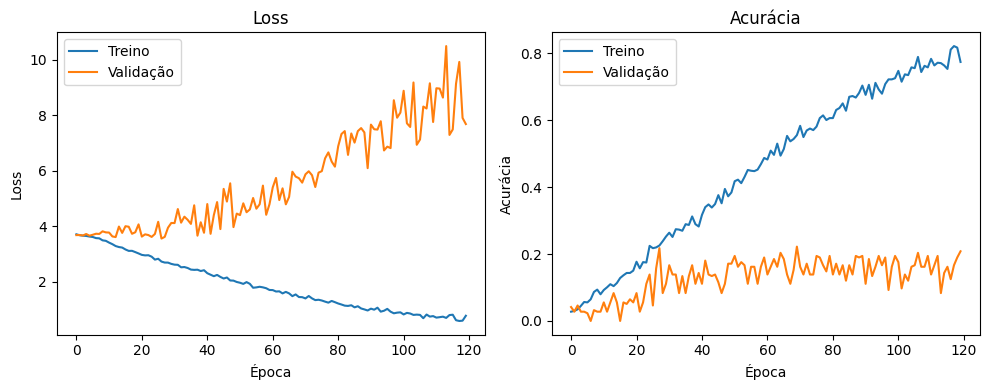

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


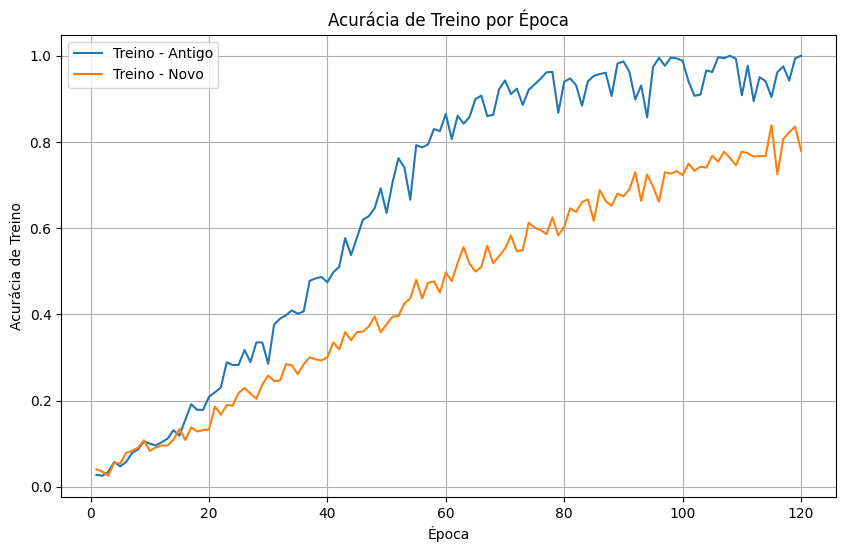

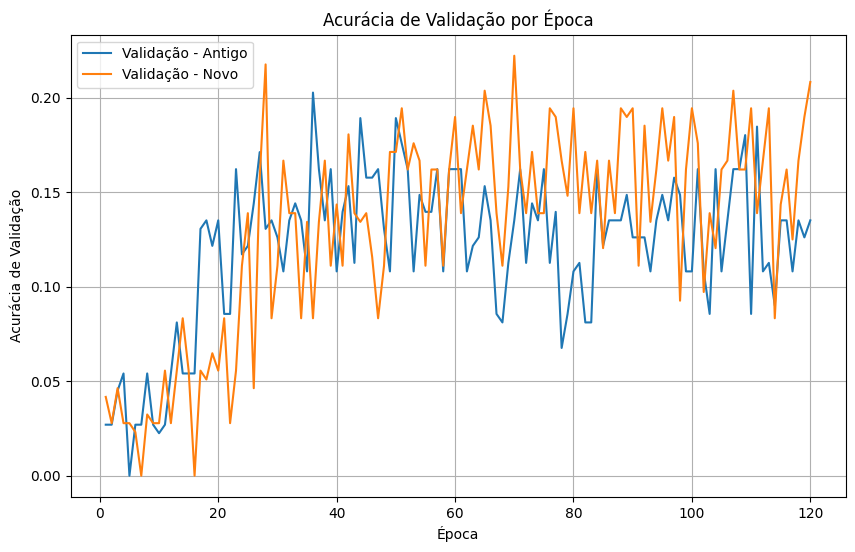

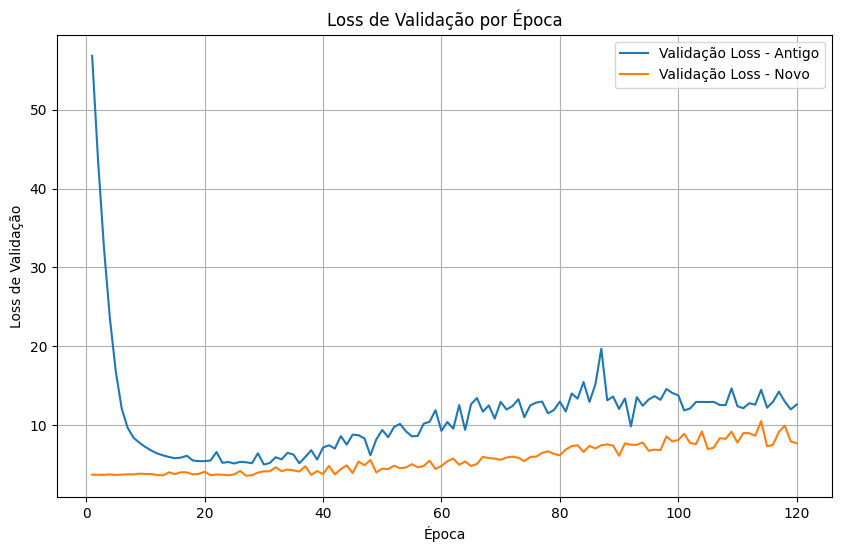

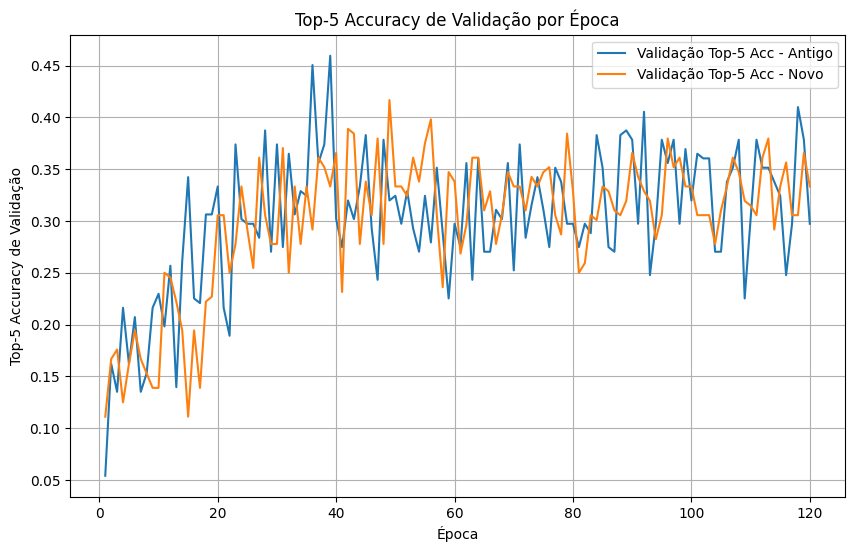

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar o arquivo CSV (coloque o caminho correto se estiver em outro local)
df = pd.read_csv('/content/drive/MyDrive/comparacao_modelos.csv')

# Gráfico 1: Acurácia de treino por época
plt.figure(figsize=(10, 6))
for modelo in df['modelo'].unique():
    modelo_df = df[df['modelo'] == modelo]
    plt.plot(modelo_df['epoch'], modelo_df['train_accuracy'], label=f'Treino - {modelo}')
plt.xlabel('Época')
plt.ylabel('Acurácia de Treino')
plt.title('Acurácia de Treino por Época')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 2: Acurácia de validação por época
plt.figure(figsize=(10, 6))
for modelo in df['modelo'].unique():
    modelo_df = df[df['modelo'] == modelo]
    plt.plot(modelo_df['epoch'], modelo_df['val_accuracy'], label=f'Validação - {modelo}')
plt.xlabel('Época')
plt.ylabel('Acurácia de Validação')
plt.title('Acurácia de Validação por Época')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 3: Loss de validação por época
plt.figure(figsize=(10, 6))
for modelo in df['modelo'].unique():
    modelo_df = df[df['modelo'] == modelo]
    plt.plot(modelo_df['epoch'], modelo_df['val_loss'], label=f'Validação Loss - {modelo}')
plt.xlabel('Época')
plt.ylabel('Loss de Validação')
plt.title('Loss de Validação por Época')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 4: Top-5 Accuracy de validação por época
plt.figure(figsize=(10, 6))
for modelo in df['modelo'].unique():
    modelo_df = df[df['modelo'] == modelo]
    plt.plot(modelo_df['epoch'], modelo_df['val_top5_acc'], label=f'Validação Top-5 Acc - {modelo}')
plt.xlabel('Época')
plt.ylabel('Top-5 Accuracy de Validação')
plt.title('Top-5 Accuracy de Validação por Época')
plt.legend()
plt.grid(True)
plt.show()
